In [38]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [39]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Reading data from crossdock dataset

In [40]:
# # Function to read all SDF files and convert to mol objects
# def read_sdf_files_from_folders(main_folder):
#     mol_list = []

#     # Traverse the main folder and subfolders
#     for root, dirs, files in os.walk(main_folder):
#         for file in files:
#             # Check if the file is a .sdf file
#             if file.endswith(".sdf"):
#                 sdf_path = os.path.join(root, file)
                
#                 # Use RDKit to read the .sdf file
#                 supplier = Chem.SDMolSupplier(sdf_path)
                
#                 # Add each mol from the .sdf file to the list
#                 for mol in supplier:
#                     if mol is not None:  # Ensure mol is valid
#                         mol_list.append(mol)
    
#     return mol_list

# # Example usage
# main_folder = '/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets'  # Replace with your folder path
# molecules = read_sdf_files_from_folders(main_folder)

# # You can now work with the list of mol objects
# print(f"Number of molecules read: {len(molecules)}")

In [41]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets/crossdock_ligand_smi.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

11602


11602

Set the default image size

In [42]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [43]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...
...                                                  ...
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O
11598                          NC[C@@H](O)c1ccc(O)c(O)c1
11599                              N[C@H](C=O)CC1=NC=NC1
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...

[11602 rows x 1 columns]

Remove repeated molecules

In [44]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

SMILES
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...
...                                                  ...
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O
11598                          NC[C@@H](O)c1ccc(O)c(O)c1
11599                              N[C@H](C=O)CC1=NC=NC1
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...

[11602 rows x 1 columns]

Save the smi file for further use

In [45]:
smi_export_list = df['SMILES'].tolist()
with open('crossdock_ligand_smi.smi', 'w') as f:
    for item in smi_export_list:
        f.write("%s\n" % item)

Add an RDKit molecule to the dataframe

In [46]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

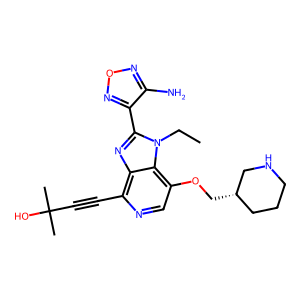

In [47]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [48]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                    [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]
1                              [c1ncc2nc[nH]c2n1, C1CCOC1]
2                              [c1ncc2nc[nH]c2n1, C1CCOC1]
3                              [c1ncc2nc[nH]c2n1, C1CCOC1]
4        [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...
                               ...                        
11597                                         [O=C1C=CCS1]
11598                                           [c1ccccc1]
11599                                          [C1=NC=NC1]
11600               [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]
11601               [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]
Name: ring_sytems, Length: 11602, dtype: object

In [49]:
df.ring_sytems.values

array([list(['c1cc2[nH]cnc2cn1', 'c1cnon1', 'C1CCNCC1']),
       list(['c1ncc2nc[nH]c2n1', 'C1CCOC1']),
       list(['c1ncc2nc[nH]c2n1', 'C1CCOC1']), ..., list(['C1=NC=NC1']),
       list(['c1ncc2nc[nH]c2n1', 'C1CCOC1', 'C1=NCN=C1']),
       list(['c1ncc2nc[nH]c2n1', 'C1CCOC1', 'C1=NC=NC1'])], dtype=object)

See how many times each ring system occurs

In [50]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
7                                             c1ccccc1   8908
9                                             c1ccncc1   1195
4                                              C1CCOC1    685
2                                             C1CCNCC1    633
8                                             C1CCOCC1    532
..                                                 ...    ...
832                               O=c1nc[nH]c2c1=NCN=2      1
834  O=C1CCNC(=O)CNC(=O)[C@@H]2CS[C@@H](N2)c2csc(n2...      1
835    O=C1CCNC(=O)CNC(=O)[C@@H]2CSC(=N2)c2cccc(n2)CN1      1
836     O=C1CCNC(=O)CNC(=O)[C@@H]2CSC(N2)c2ccnc(c2)CN1      1
885                         C1=CC2=Nc3ccccc3N[C@H]2CC1      1

[2109 rows x 2 columns]

View the ring system frequencies

In [51]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [52]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

[20:34:25] bond type above 3 (17) is treated as unspecified!
[20:34:25] Invalid InChI prefix in generating InChI Key
[20:34:27] unrecognized chirality tag (8) on atom 10 is ignored.
[20:34:32] unrecognized chirality tag (8) on atom 12 is ignored.
[20:34:33] unrecognized chirality tag (8) on atom 12 is ignored.
[20:34:33] unrecognized chirality tag (8) on atom 2 is ignored.
[20:34:33] unrecognized chirality tag (8) on atom 12 is ignored.
[20:34:33] unrecognized chirality tag (8) on atom 3 is ignored.
[20:34:35] unrecognized chirality tag (6) on atom 7 is ignored.
[20:34:35] unrecognized chirality tag (6) on atom 2 is ignored.


In [53]:
res

0        [(c1cc2[nH]cnc2cn1, 2525), (c1cnon1, 2243), (C...
1            [(c1ncc2nc[nH]c2n1, 24411), (C1CCOC1, 47269)]
2            [(c1ncc2nc[nH]c2n1, 24411), (C1CCOC1, 47269)]
3            [(c1ncc2nc[nH]c2n1, 24411), (C1CCOC1, 47269)]
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11597                                  [(O=C1C=CCS1, 222)]
11598                                [(c1ccccc1, 2260082)]
11599                                    [(C1=NC=NC1, 26)]
11600    [(c1ncc2nc[nH]c2n1, 24411), (C1CCOC1, 47269), ...
11601    [(c1ncc2nc[nH]c2n1, 24411), (C1CCOC1, 47269), ...
Name: mol, Length: 11602, dtype: object

In [54]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7211179eee30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7210dff93840>   
2      <rdkit.Chem.rdchem.Mol object at 0x7210dff938b0>   
3      <rdkit.Chem.rdchem.Mol object at 0x7210dff93920>   
4      <rdkit.Chem.rdchem.Mol object at 0x7210dff93990>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d35a0>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3610>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3680>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d36f0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3760>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  
0                                                c1cnon1     2243  
1                                       c1ncc2nc[nH]c2n1    24411  
2                                       c1ncc2nc[nH]c2n1    24411  
3                                       c1ncc2nc[nH]c2n1    24411  
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0  
...                                                  ...      ...  
11597                                         O=C1C=CCS1      222  
11598                                           c1ccccc1  2260082  
11599                                          C1=NC=NC1       26  
11600                                          C1=NCN=C1       61  
11601                                          C1=NC=NC1       26  

[11602 rows x 5 columns]

In [55]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [56]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Omitted undefined stereo

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Charges were rearranged

[20:34:36] WARNING: Omitted undefined ste

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7211179eee30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7210dff93840>   
2      <rdkit.Chem.rdchem.Mol object at 0x7210dff938b0>   
3      <rdkit.Chem.rdchem.Mol object at 0x7210dff93920>   
4      <rdkit.Chem.rdchem.Mol object at 0x7210dff93990>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d35a0>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3610>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3680>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d36f0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3760>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
1                                       c1ncc2nc[nH]c2n1    24411   
2                                       c1ncc2nc[nH]c2n1    24411   
3                                       c1ncc2nc[nH]c2n1    24411   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   
11600                                          C1=NCN=C1       61   
11601                                          C1=NC=NC1       26   

                                                   inchi  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...  
...                                                  ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...  

[11602 rows x 6 columns]

How many of them have ring system?

In [57]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7211179eee30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7210dff93840>   
2      <rdkit.Chem.rdchem.Mol object at 0x7210dff938b0>   
3      <rdkit.Chem.rdchem.Mol object at 0x7210dff93920>   
4      <rdkit.Chem.rdchem.Mol object at 0x7210dff93990>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d35a0>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3610>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3680>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d36f0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3760>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
1                                       c1ncc2nc[nH]c2n1    24411   
2                                       c1ncc2nc[nH]c2n1    24411   
3                                       c1ncc2nc[nH]c2n1    24411   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   
11600                                          C1=NCN=C1       61   
11601                                          C1=NC=NC1       26   

                                                   inchi  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...  
...                                                  ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...  

[10881 rows x 6 columns]

In [58]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11585  Nc1ncnc2c1nc(Br)n2[C@@H]1O[C@H](CO[P@@](=O)(O)...   
11595         CN(CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O   
11596                          CC(=O)c1sc(Nc2ccccc2)nc1C   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7211179eee30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7210dff93840>   
2      <rdkit.Chem.rdchem.Mol object at 0x7210dff938b0>   
3      <rdkit.Chem.rdchem.Mol object at 0x7210dff93920>   
5      <rdkit.Chem.rdchem.Mol object at 0x7210dff93a00>   
...                                                 ...   
11585  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3060>   
11595  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d34c0>   
11596  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3530>   
11597  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d35a0>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3610>   

                                 ring_sytems                   min_ring  \
0      [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]                    c1cnon1   
1                [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
2                [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
3                [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
5      [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
...                                      ...                        ...   
11585            [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
11595                             [c1ccccc1]                   c1ccccc1   
11596                    [c1cscn1, c1ccccc1]                    c1cscn1   
11597                           [O=C1C=CCS1]                 O=C1C=CCS1   
11598                             [c1ccccc1]                   c1ccccc1   

      min_freq                                              inchi  
0         2243  InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1        24411  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2        24411  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3        24411  InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...  
5         1897  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...  
...        ...                                                ...  
11585    24411  InChI=1S/C10H14BrN5O10P2/c11-10-15-4-7(12)13-2...  
11595  2260082  InChI=1S/C14H25NO7P2/c1-15(11-6-5-9-13-7-3-2-4...  
11596    61036  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...  
11597      222  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11598  2260082  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  

[8023 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [59]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [60]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [61]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [62]:
reos.pandas_mols(df.mol)

  0%|          | 0/11602 [00:00<?, ?it/s]

rule_set_name     description
0                ok              ok
1                ok              ok
2                ok              ok
3                ok              ok
4             PAINS      dyes5A(27)
...             ...             ...
11597            ok              ok
11598         PAINS  catechol_A(92)
11599            ok              ok
11600            ok              ok
11601            ok              ok

[11602 rows x 2 columns]

In [63]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/11602 [00:00<?, ?it/s]

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11596                          CC(=O)c1sc(Nc2ccccc2)nc1C   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7211179eee30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7210dff93840>   
2      <rdkit.Chem.rdchem.Mol object at 0x7210dff938b0>   
3      <rdkit.Chem.rdchem.Mol object at 0x7210dff93920>   
5      <rdkit.Chem.rdchem.Mol object at 0x7210dff93a00>   
...                                                 ...   
11596  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3530>   
11597  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d35a0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3680>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d36f0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7210dd3d3760>   

                                  ring_sytems                   min_ring  \
0       [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]                    c1cnon1   
1                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
2                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
3                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
5       [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
...                                       ...                        ...   
11596                     [c1cscn1, c1ccccc1]                    c1cscn1   
11597                            [O=C1C=CCS1]                 O=C1C=CCS1   
11599                             [C1=NC=NC1]                  C1=NC=NC1   
11600  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]                  C1=NCN=C1   
11601  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]                  C1=NC=NC1   

      min_freq                                              inchi  \
0         2243  InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...   
1        24411  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
2        24411  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
3        24411  InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...   
5         1897  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...   
...        ...                                                ...   
11596    61036  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...   
11597      222  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...   
11599       26  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...   
11600       61  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...   
11601       26  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...   

      rule_set_name description  
0                ok          ok  
1                ok          ok  
2                ok          ok  
3                ok          ok  
5                ok          ok  
...             ...         ...  
11596            ok          ok  
11597            ok          ok  
11599            ok          ok  
11600            ok          ok  
11601            ok          ok  

[11178 rows x 8 columns]

Test all filters from rd filters

In [64]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/11602 [00:00<?, ?it/s]

Glaxo 0.9206171349767281 ['Glaxo'] 10681


  0%|          | 0/11602 [00:00<?, ?it/s]

Dundee 0.5574038958800207 ['Dundee'] 6467


  0%|          | 0/11602 [00:00<?, ?it/s]

BMS 0.8609722461644544 ['BMS'] 9989


  0%|          | 0/11602 [00:00<?, ?it/s]

SureChEMBL 0.7761592828822617 ['SureChEMBL'] 9005


  0%|          | 0/11602 [00:00<?, ?it/s]

MLSMR 0.47267712463368383 ['MLSMR'] 5484


  0%|          | 0/11602 [00:00<?, ?it/s]

Inpharmatica 0.7898638165833477 ['Inpharmatica'] 9164


  0%|          | 0/11602 [00:00<?, ?it/s]

LINT 0.5436993621789347 ['LINT'] 6308


### How many of them could pass filters suggested by Dr.Reymond?

In [27]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
4      <rdkit.Chem.rdchem.Mol object at 0x7211179eeff0>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
1                                       c1ncc2nc[nH]c2n1    24411   
2                                       c1ncc2nc[nH]c2n1    24411   
3                                       c1ncc2nc[nH]c2n1    24411   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   
11600                                          C1=NCN=C1       61   
11601                                          C1=NC=NC1       26   

                                                   inchi  Reymond  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...     True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True  
...                                                  ...      ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...     True  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...     True  

[11602 rows x 7 columns]

In [28]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
4      <rdkit.Chem.rdchem.Mol object at 0x7211179eeff0>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
1                                       c1ncc2nc[nH]c2n1    24411   
2                                       c1ncc2nc[nH]c2n1    24411   
3                                       c1ncc2nc[nH]c2n1    24411   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   
11600                                          C1=NCN=C1       61   
11601                                          C1=NC=NC1       26   

                                                   inchi  Reymond  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...     True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True  
...                                                  ...      ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...     True  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...     True  

[11582 rows x 7 columns]

### How many of them could pass RO5?

In [29]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
4      <rdkit.Chem.rdchem.Mol object at 0x7211179eeff0>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
1                                       c1ncc2nc[nH]c2n1    24411   
2                                       c1ncc2nc[nH]c2n1    24411   
3                                       c1ncc2nc[nH]c2n1    24411   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   
11600                                          C1=NCN=C1       61   
11601                                          C1=NC=NC1       26   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
...                                                  ...      ...       ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...     True      True  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...     True     False  

[11602 rows x 8 columns]

In [30]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
6      O=[N+]([O-])c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[...   
7      CC(=O)N[C@H]1[C@H](Oc2ccc([N+](=O)[O-])cc2)O[C...   
...                                                  ...   
11595         CN(CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O   
11596                          CC(=O)c1sc(Nc2ccccc2)nc1C   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
4      <rdkit.Chem.rdchem.Mol object at 0x7211179eeff0>   
5      <rdkit.Chem.rdchem.Mol object at 0x7211179ef060>   
6      <rdkit.Chem.rdchem.Mol object at 0x7211179ef0d0>   
7      <rdkit.Chem.rdchem.Mol object at 0x7211179ef140>   
...                                                 ...   
11595  <rdkit.Chem.rdchem.Mol object at 0x72111452e7a0>   
11596  <rdkit.Chem.rdchem.Mol object at 0x72111452e810>   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
5                  [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
6                                   [c1ccccc1, C1CCOCC1]   
7                                   [C1CCOCC1, c1ccccc1]   
...                                                  ...   
11595                                         [c1ccccc1]   
11596                                [c1cscn1, c1ccccc1]   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   

                                                min_ring min_freq  \
0                                                c1cnon1     2243   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
5                              O=C1NC(=O)c2cccc3cccc1c23     1897   
6                                               C1CCOCC1    64272   
7                                               C1CCOCC1    64272   
...                                                  ...      ...   
11595                                           c1ccccc1  2260082   
11596                                            c1cscn1    61036   
11597                                         O=C1C=CCS1      222   
11598                                           c1ccccc1  2260082   
11599                                          C1=NC=NC1       26   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
6      InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...     True      True  
7      InChI=1S/C14H18N2O8/c1-7(18)15-11-13(20)12(19)...     True      True  
...                                                  ...      ...       ...  
11595  InChI=1S/C14H25NO7P2/c1-15(11-6-5-9-13-7-3-2-4...     True      True  
11596  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...     True      True  

[8560 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [31]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

[11:12:53] bond type above 3 (17) is treated as unspecified!
[11:12:53] Invalid InChI prefix in generating InChI Key
[11:12:55] unrecognized chirality tag (8) on atom 10 is ignored.
[11:12:59] unrecognized chirality tag (8) on atom 12 is ignored.
[11:13:00] unrecognized chirality tag (8) on atom 12 is ignored.
[11:13:00] unrecognized chirality tag (8) on atom 2 is ignored.
[11:13:00] unrecognized chirality tag (8) on atom 12 is ignored.
[11:13:00] unrecognized chirality tag (8) on atom 3 is ignored.
[11:13:02] unrecognized chirality tag (6) on atom 7 is ignored.
[11:13:02] unrecognized chirality tag (6) on atom 2 is ignored.


0        [(c1cc2[nH]cnc2cn1, 24647012), (c1cnon1, 10838...
1        [(c1ncc2nc[nH]c2n1, 72492350), (C1CCOC1, 41510...
2        [(c1ncc2nc[nH]c2n1, 72492350), (C1CCOC1, 41510...
3        [(c1ncc2nc[nH]c2n1, 72492350), (C1CCOC1, 41510...
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11597                                   [(O=C1C=CCS1, 22)]
11598                            [(c1ccccc1, 21243538754)]
11599                                   [(C1=NC=NC1, 110)]
11600    [(c1ncc2nc[nH]c2n1, 72492350), (C1CCOC1, 41510...
11601    [(c1ncc2nc[nH]c2n1, 72492350), (C1CCOC1, 41510...
Name: mol, Length: 11602, dtype: object

In [32]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
4      <rdkit.Chem.rdchem.Mol object at 0x7211179eeff0>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                             ring_sytems  \
0                  [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]   
1                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
2                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
3                            [c1ncc2nc[nH]c2n1, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11597                                       [O=C1C=CCS1]   
11598                                         [c1ccccc1]   
11599                                        [C1=NC=NC1]   
11600             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]   
11601             [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]   

                                                min_ring     min_freq  \
0                                       c1cc2[nH]cnc2cn1     24647012   
1                                       c1ncc2nc[nH]c2n1     72492350   
2                                       c1ncc2nc[nH]c2n1     72492350   
3                                       c1ncc2nc[nH]c2n1     72492350   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...            0   
...                                                  ...          ...   
11597                                         O=C1C=CCS1           22   
11598                                           c1ccccc1  21243538754   
11599                                          C1=NC=NC1          110   
11600                                          C1=NCN=C1           36   
11601                                          C1=NC=NC1          110   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
...                                                  ...      ...       ...  
11597  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11598  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11599  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...     True      True  
11600  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  
11601  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...     True     False  

[11602 rows x 8 columns]

In [33]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [34]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11595         CN(CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O   
11596                          CC(=O)c1sc(Nc2ccccc2)nc1C   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
5      <rdkit.Chem.rdchem.Mol object at 0x7211179ef060>   
...                                                 ...   
11595  <rdkit.Chem.rdchem.Mol object at 0x72111452e7a0>   
11596  <rdkit.Chem.rdchem.Mol object at 0x72111452e810>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                  ring_sytems                   min_ring  \
0       [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]           c1cc2[nH]cnc2cn1   
1                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
2                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
3                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
5       [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
...                                       ...                        ...   
11595                              [c1ccccc1]                   c1ccccc1   
11596                     [c1cscn1, c1ccccc1]                    c1cscn1   
11598                              [c1ccccc1]                   c1ccccc1   
11599                             [C1=NC=NC1]                  C1=NC=NC1   
11601  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]                  C1=NC=NC1   

          min_freq                                              inchi  \
0         24647012  InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...   
1         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
2         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
3         72492350  InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...   
5            87416  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...   
...            ...                                                ...   
11595  21243538754  InChI=1S/C14H25NO7P2/c1-15(11-6-5-9-13-7-3-2-4...   
11596   3866438902  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...   
11598  21243538754  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...   
11599          110  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...   
11601          110  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...   

       Reymond  Lipinski  
0         True      True  
1         True     False  
2         True     False  
3         True     False  
5         True      True  
...        ...       ...  
11595     True      True  
11596     True      True  
11598     True      True  
11599     True      True  
11601     True     False  

[8268 rows x 8 columns]

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
5      <rdkit.Chem.rdchem.Mol object at 0x7211179ef060>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                  ring_sytems                   min_ring  \
0       [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]           c1cc2[nH]cnc2cn1   
1                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
2                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
3                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
5       [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
...                                       ...                        ...   
11597                            [O=C1C=CCS1]                 O=C1C=CCS1   
11598                              [c1ccccc1]                   c1ccccc1   
11599                             [C1=NC=NC1]                  C1=NC=NC1   
11600  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]                  C1=NCN=C1   
11601  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]                  C1=NC=NC1   

          min_freq                                              inchi  \
0         24647012  InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...   
1         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
2         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
3         72492350  InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...   
5            87416  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...   
...            ...                                                ...   
11597           22  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...   
11598  21243538754  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...   
11599          110  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...   
11600           36  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...   
11601          110  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...   

       Reymond  Lipinski  
0         True      True  
1         True     False  
2         True     False  
3         True     False  
5         True      True  
...        ...       ...  
11597     True      True  
11598     True      True  
11599     True      True  
11600     True     False  
11601     True     False  

[9282 rows x 8 columns]

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x721120393f40>   
1      <rdkit.Chem.rdchem.Mol object at 0x7211179eec70>   
2      <rdkit.Chem.rdchem.Mol object at 0x7211179eef10>   
3      <rdkit.Chem.rdchem.Mol object at 0x7211179eef80>   
5      <rdkit.Chem.rdchem.Mol object at 0x7211179ef060>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x72111452e880>   
11598  <rdkit.Chem.rdchem.Mol object at 0x72111452e8f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x72111452e960>   
11600  <rdkit.Chem.rdchem.Mol object at 0x72111452e9d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x72111452ea40>   

                                  ring_sytems                   min_ring  \
0       [c1cc2[nH]cnc2cn1, c1cnon1, C1CCNCC1]           c1cc2[nH]cnc2cn1   
1                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
2                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
3                 [c1ncc2nc[nH]c2n1, C1CCOC1]           c1ncc2nc[nH]c2n1   
5       [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
...                                       ...                        ...   
11597                            [O=C1C=CCS1]                 O=C1C=CCS1   
11598                              [c1ccccc1]                   c1ccccc1   
11599                             [C1=NC=NC1]                  C1=NC=NC1   
11600  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NCN=C1]                  C1=NCN=C1   
11601  [c1ncc2nc[nH]c2n1, C1CCOC1, C1=NC=NC1]                  C1=NC=NC1   

          min_freq                                              inchi  \
0         24647012  InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...   
1         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
2         72492350  InChI=1S/C10H16N5O12P3S/c11-8-5-9(13-2-12-8)15...   
3         72492350  InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...   
5            87416  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...   
...            ...                                                ...   
11597           22  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...   
11598  21243538754  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...   
11599          110  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h3-5H...   
11600           36  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...   
11601          110  InChI=1S/C16H21N8O8P/c17-8(1-7-2-19-4-20-7)16(...   

       Reymond  Lipinski  
0         True      True  
1         True     False  
2         True     False  
3         True     False  
5         True      True  
...        ...       ...  
11597     True      True  
11598     True      True  
11599     True      True  
11600     True     False  
11601     True     False  

[8714 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [50]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

[21:53:01] bond type above 3 (17) is treated as unspecified!
[21:53:01] Invalid InChI prefix in generating InChI Key
[21:53:03] unrecognized chirality tag (8) on atom 10 is ignored.
[21:53:08] unrecognized chirality tag (8) on atom 12 is ignored.
[21:53:10] unrecognized chirality tag (8) on atom 12 is ignored.
[21:53:10] unrecognized chirality tag (8) on atom 2 is ignored.
[21:53:10] unrecognized chirality tag (8) on atom 12 is ignored.
[21:53:10] unrecognized chirality tag (8) on atom 3 is ignored.
[21:53:11] unrecognized chirality tag (6) on atom 7 is ignored.
[21:53:12] unrecognized chirality tag (6) on atom 2 is ignored.


0        [(c1cc2[nH]cnc2cn1, 185019), (c1cnon1, 2572424...
1        [(c1ncc2nc[nH]c2n1, 608111), (C1CCOC1, 34263706)]
2        [(c1ncc2nc[nH]c2n1, 608111), (C1CCOC1, 34263706)]
3        [(c1ncc2nc[nH]c2n1, 608111), (C1CCOC1, 34263706)]
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11597                                   [(O=C1C=CCS1, 12)]
11598                              [(c1ccccc1, 503413992)]
11599                                  [(C1=NC=NC1, 5032)]
11600    [(c1ncc2nc[nH]c2n1, 608111), (C1CCOC1, 3426370...
11601    [(c1ncc2nc[nH]c2n1, 608111), (C1CCOC1, 3426370...
Name: mol, Length: 11602, dtype: object

In [51]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11597                    C=C/C=C/[C@@]1(C)SC(=O)C(C)=C1O   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11600  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O)[C@...   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7d4e7e106e30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0820>   
2      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0890>   
3      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0900>   
4      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0970>   
...                                                 ...   
11597  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130580>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7d4e481305f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130660>   
11600  <rdkit.Chem.rdchem.Mol object at 0x7d4e481306d0>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130740>   

                                                min_ring   min_freq  
0                                       c1cc2[nH]cnc2cn1     185019  
1                                       c1ncc2nc[nH]c2n1     608111  
2                                       c1ncc2nc[nH]c2n1     608111  
3                                       c1ncc2nc[nH]c2n1     608111  
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...          0  
...                                                  ...        ...  
11597                                         O=C1C=CCS1         12  
11598                                           c1ccccc1  503413992  
11599                                          C1=NC=NC1       5032  
11600                                          C1=NCN=C1         90  
11601                                          C1=NC=NC1       5032  

[11602 rows x 4 columns]

In [52]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [53]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3C...   
1      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
2      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@...   
3      Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11595         CN(CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O   
11596                          CC(=O)c1sc(Nc2ccccc2)nc1C   
11598                          NC[C@@H](O)c1ccc(O)c(O)c1   
11599                              N[C@H](C=O)CC1=NC=NC1   
11601  Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OC(=...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7d4e7e106e30>   
1      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0820>   
2      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0890>   
3      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f0900>   
5      <rdkit.Chem.rdchem.Mol object at 0x7d4e3f5f09e0>   
...                                                 ...   
11595  <rdkit.Chem.rdchem.Mol object at 0x7d4e481304a0>   
11596  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130510>   
11598  <rdkit.Chem.rdchem.Mol object at 0x7d4e481305f0>   
11599  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130660>   
11601  <rdkit.Chem.rdchem.Mol object at 0x7d4e48130740>   

                        min_ring   min_freq  
0               c1cc2[nH]cnc2cn1     185019  
1               c1ncc2nc[nH]c2n1     608111  
2               c1ncc2nc[nH]c2n1     608111  
3               c1ncc2nc[nH]c2n1     608111  
5      O=C1NC(=O)c2cccc3cccc1c23      19177  
...                          ...        ...  
11595                   c1ccccc1  503413992  
11596                    c1cscn1   35701361  
11598                   c1ccccc1  503413992  
11599                  C1=NC=NC1       5032  
11601                  C1=NC=NC1       5032  

[7984 rows x 4 columns]